In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import seaborn as sns

import pandas as pd
from sklearn import cluster, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torch.nn.functional as Func
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

In [2]:
# Load data
f = pd.read_csv("data.csv")
f.rename(columns={'time sample band g': 'time_g', 'time sample band r': 'time_r',
                    'time sample band i': 'time_i','total flux + noise band g': 'tfnbg',
                    'total flux + noise band r': 'tfnbr', 'total flux + noise band i': 'tfnbi',}, inplace=True)

In [3]:
f['images'] = f['images'].replace([1, 2, 3, 4], [0, 1, 1, 1])

In [4]:
train = f[:91*8000]
val = f[91*8000:91*9000]
test = f[91*9000:]

In [5]:
print((train['images']==0).sum())
print((train['images']==1).sum())


print((test['images']==0).sum())
print((test['images']==1).sum())

362999
365001
45591
45409


In [6]:
def dataframe_to_dataset(f):
        
    scaler = MinMaxScaler(feature_range = (0, 1), copy=False)
    #scaler = StandardScaler()

    features_columns = f.columns.tolist()[3::2]
    T = []
    F = []
    
    for ide, group in f.groupby('ID'):

        a = f[f.ID == ide]
        c = a[['ID', 'images']]
        data = a.copy()
        #t = ['time_g', 'time_r', 'time_i']
        
        data[['tfnbg', 'tfnbr', 'tfnbi']] = scaler.fit_transform(data[['tfnbg', 'tfnbr', 'tfnbi']])
        #data[t] = data[t]-np.min(data[t])

        T.append(a['images'].values[0])
        F.append(torch.tensor(data[features_columns].T.values)[None])

    
    T = torch.tensor(T)
    F = torch.cat(F, dim=0)
    print(F.shape)
    return TensorDataset(F.double(), T.double())

In [7]:
TrainSet = dataframe_to_dataset(train)
TestSet = dataframe_to_dataset(test)
ValSet = dataframe_to_dataset(val)

torch.Size([8000, 3, 91])
torch.Size([1000, 3, 91])
torch.Size([1000, 3, 91])


In [8]:
TrainSet

In [20]:
class SequenceModel(nn.Module):
    
    def __init__(self, n_channels, n_classes, n_hidden=64):
        
        super().__init__()
        
        self.conv1 = nn.Conv1d(3, 16, kernel_size=(5,))
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(16,32, kernel_size=(5,))
        
        #self.lstm1 = nn.Conv1d(
        #in_channels = n_channels,
        #out_channels = n_hidden,
        #kernel_size = 5)
        #self.lstm1 = nn.LSTM(
        #    input_size = n_channels,
        #    hidden_size = n_hidden,
        #    num_layers = 5) 
        
        #self.lstm2 = nn.Conv1d(
        #in_channels = n_hidden,
        #out_channels = 128,
        #kernel_size = 5)
        
        self.c1 = nn.Linear(608, 512)
        self.c2 = nn.Linear(512, 128)
        self.c3 = nn.Linear(608, n_classes-1)
            
        
    def forward(self, x):
        #x, (ht, ct) = self.lstm1(x) 
        x = self.pool(Func.relu(self.conv1(x)))
        print(x.shape)
        x = self.pool(Func.relu(self.conv2(x)))
        print(x.shape)
        #x = self.lstm1(x)
        x = torch.flatten(x, 1)
        print(x.shape)
        #x= self.c1(x)
        #x = self.c2(x)
        pred = self.c3(x)
        print(pred.shape)
        #pred = torch.sigmoid(pred)
        return pred

In [21]:
torch.manual_seed(0)

In [22]:
model = SequenceModel(n_channels = 3, 
                        n_classes = 2)
model = model.double()

In [23]:
print(model)

SequenceModel(
  (conv1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,))
  (c1): Linear(in_features=608, out_features=512, bias=True)
  (c2): Linear(in_features=512, out_features=128, bias=True)
  (c3): Linear(in_features=608, out_features=1, bias=True)
)


In [24]:
TrainLoader = data_utils.DataLoader(TrainSet, batch_size = 5, shuffle = True)
ValLoader = data_utils.DataLoader(ValSet, batch_size = 16, shuffle = False)
TestLoader = data_utils.DataLoader(TestSet, batch_size = 16, shuffle = False)

In [25]:
loss_function = torch.nn.BCEWithLogitsLoss()

In [26]:
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [27]:
print("--- State_dict du model : ---")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print()

--- State_dict du model : ---
conv1.weight 	 torch.Size([16, 3, 5])
conv1.bias 	 torch.Size([16])
conv2.weight 	 torch.Size([32, 16, 5])
conv2.bias 	 torch.Size([32])
c1.weight 	 torch.Size([512, 608])
c1.bias 	 torch.Size([512])
c2.weight 	 torch.Size([128, 512])
c2.bias 	 torch.Size([128])
c3.weight 	 torch.Size([1, 608])
c3.bias 	 torch.Size([1])



In [28]:
losses = []  

N_epochs = 10
n_verbose = 100
smooth_loss = []
accuracy = 0
acc_loss = []

for epoch in range(N_epochs):  # Loop over epochs
    print(f'Running epoch {epoch+1}')
    running_loss = 0.0
    for i, (features, label) in enumerate(TrainLoader):
        #print(features.shape)
        # Erase previous gradients
        optimizer.zero_grad()
        
        #print(features.shape)
        labels_pred =[]
        # Forward Propagation 
        labels_pred = model(features)  
        #print(labels_pred.shape)
        
        #print(labels_pred)
        #label = tensor(np.array(label[0].item()))   # for size 2 in output of the model
        #label = torch.tensor([label[0].item()]).to(torch.float)
        
        
        # Loss computation
        loss = loss_function(labels_pred, label[..., None])
        #val_loss = loss_function(labels_val_pred, labels_val)
        # Save loss for future analysis
        #losses.append(loss.item())
        #val_losses.append(val_loss)
        
        # Compute gradients (backpropagation)
        loss.backward()
        
        # Weight update
        optimizer.step()
        # ACcuracy:
        labels_pred[labels_pred<0.5] = 0
        labels_pred[labels_pred>=0.5] = 1

        accuracy = torch.add(accuracy, torch.sum(labels_pred-label))
        

        # print statistics
        running_loss += loss.item()
        losses.append(loss.item())
        if i % n_verbose == n_verbose-1:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / n_verbose:.5f}, accuracy: {accuracy/n_verbose:.5f}')
            smooth_loss.append(running_loss / n_verbose)
            acc_loss.append(accuracy.detach().numpy()/n_verbose)
            running_loss = 0.0
            accuracy = 0.
    plt.plot(np.log10(np.array(losses)), label = 'loss')
    plt.plot(np.arange(len(smooth_loss))*n_verbose+n_verbose/2., np.log10(np.array(smooth_loss)), label='smooth loss')
    #plt.ylim([0,1])
    plt.legend()
    plt.show()
    plt.plot(np.arange(len(smooth_loss))*n_verbose+n_verbose/2., np.array(acc_loss), label = 'accuracy')
    plt.legend()
    plt.show()
    

Running epoch 1
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 1

torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Si

torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Si

torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
[1,   500] loss: 0.68505, accuracy: -12.65000
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size

torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Si

torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Si

torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Si

torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Size([5, 32, 19])
torch.Size([5, 608])
torch.Size([5, 1])
torch.Size([5, 16, 43])
torch.Si

KeyboardInterrupt: 

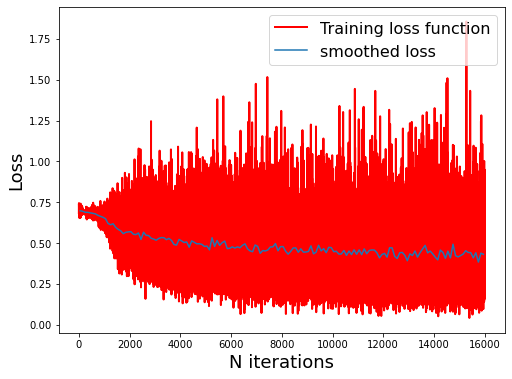

In [18]:
# Display loss evolution
fig, axes = plt.subplots(figsize=(8,6))
axes.plot(losses,'r-',lw=2,label='Training loss function')
plt.plot(np.arange(len(smooth_loss))*n_verbose+n_verbose/2., (np.array(smooth_loss)), label = 'smoothed loss')
#axes.plot(val_losses,'b-',lw=2,label='Validation loss function')
axes.set_xlabel('N iterations',fontsize=18)
axes.set_ylabel('Loss',fontsize=18)
#plt.ylim([0, 1])
plt.legend(loc='upper right',fontsize=16)

In [19]:
val_losses = []
for epoch in range(N_epochs):  # Loop over epochs
    running_loss = 0.0
   
    for features, labels in ValLoader:
        
        # Forward Propagation 
        labels_pred = model(features.double())
        label = torch.tensor([labels[0].item()]).to(torch.double)

        # Loss computation
        loss = loss_function(labels_pred, label)

        # Save loss for future analysis
        val_losses.append(loss.item())
        
    print('Training done')

ValueError: Target size (torch.Size([1])) must be the same as input size (torch.Size([16, 1]))

In [ ]:
# Accuracy
def accuracy(model,dataloader):
    correct = 0
    total = 0
    # No need to compute gradients here
    with torch.no_grad():
        for features, labels in dataloader:
            print(len(labels))
            # Forward propagation to get predictions
            pred = model(features.float()) 
            otherprob = 1 - pred.item()           
            outputs = torch.tensor([[pred, otherprob]])
            labels = torch.tensor([labels[0].item()]).to(torch.float)
            print(labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            #print(total)
            correct += (predicted == labels).sum().item()
    return 100.0 * correct / total       

print('Accuracy : %.2f %%' % (accuracy(model,TestLoader)))   